In [23]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.collections import LineCollection  # 新增导入LineCollection

habitat_current=xr.open_dataarray("habitat_maxent_current.nc")
habitat_585=xr.open_dataarray("habitat_maxent_ssp585dec100.nc")
habitat_sum=xr.open_dataarray("habitat_maxent_sum.nc")
PC31 = xr.open_dataset("polar_31_pred.nc")
PC42 = xr.open_dataset("polar_42_pred.nc")

PC31_his = PC31.where(PC31.Years <=2024, drop=True)
PC31_pred = PC31.where(PC31.Years >2024, drop=True)

PC42_his = PC42.where(PC42.Years <=2024, drop=True)
PC42_pred = PC42.where(PC42.Years >2024, drop=True)

habitat_maxent_current_regions=xr.open_dataset("habitat_maxent_current_regions.nc")
habitat_maxent_585_regions=xr.open_dataset("habitat_maxent_ssp585dec100_regions.nc")

In [24]:
import xarray as xr
import numpy as np

# Load datasets
pc31bg = xr.open_dataset("pc31bg.nc")
pc42bg = xr.open_dataset("pc42bg.nc")

# Split datasets into historical and prediction periods
pc31bg_his = pc31bg.where(pc31bg.Years <= 2024, drop=True)
pc31bg_pred = pc31bg.where(pc31bg.Years > 2024, drop=True)
pc42bg_his = pc42bg.where(pc42bg.Years <= 2024, drop=True)
pc42bg_pred = pc42bg.where(pc42bg.Years > 2024, drop=True)

habitat_used = habitat_585

habitat_used = habitat_used.assign_coords(
    Latitude=PC31.mhw.Latitude,
    Longitude=PC31.mhw.Longitude
)


# Filter datasets by habitat mask
PC31_f = PC31.where(habitat_used.notnull())
PC42_f = PC42.where(habitat_used.notnull())
pc31bg_f = pc31bg.where(habitat_used.notnull())
pc42bg_f = pc42bg.where(habitat_used.notnull())

# Create masks for valid data points
valid_mask31 = ~np.isnan(PC31_f.nan.values) & ~np.isnan(PC31_f.mhw.values)
valid_mask42 = ~np.isnan(PC42_f.nan.values) & ~np.isnan(PC42_f.mhw.values)

# Process PC31 data
pc31_mhw_flat = np.clip(PC31_f.mhw.values[valid_mask31].flatten(), 0, 100)
pc31_nan_flat = np.clip(PC31_f.nan.values[valid_mask31].flatten(), 0, 100)

pc31_ci_flat = pc31bg_f.CI.values[valid_mask31].flatten()
pc31_mtpmhw_flat = pc31bg_f.mtp_mhw.values[valid_mask31].flatten()
pc31_mtpnan_flat = pc31bg_f.mtp_nan.values[valid_mask31].flatten()
pc31_duramhw_flat = pc31bg_f.dura_mhw.values[valid_mask31].flatten()
pc31_duranan_flat = pc31bg_f.dura_nan.values[valid_mask31].flatten()
# Process PC42 data
pc42_mhw_flat = np.clip(PC42_f.mhw.values[valid_mask42].flatten(), 0, 100)
pc42_nan_flat = np.clip(PC42_f.nan.values[valid_mask42].flatten(), 0, 100)

pc42_ci_flat = pc42bg_f.CI.values[valid_mask42].flatten()
pc42_mtpmhw_flat = pc42bg_f.mtp_mhw.values[valid_mask42].flatten()
pc42_mtpnan_flat = pc42bg_f.mtp_nan.values[valid_mask42].flatten()
pc42_duramhw_flat = pc42bg_f.dura_mhw.values[valid_mask42].flatten()
pc42_duranan_flat = pc42bg_f.dura_nan.values[valid_mask42].flatten()
# Remove NaN values from PC31 arrays
pc31_arrays = [pc31_ci_flat, pc31_mtpmhw_flat, pc31_mtpnan_flat, 
               pc31_duramhw_flat, pc31_duranan_flat, pc31_mhw_flat, pc31_nan_flat]
for i, arr in enumerate(pc31_arrays):
    pc31_arrays[i] = arr[~np.isnan(arr)]

pc31_ci_flat, pc31_mtpmhw_flat, pc31_mtpnan_flat, pc31_duramhw_flat, pc31_duranan_flat, pc31_mhw_flat, pc31_nan_flat = pc31_arrays

# Remove NaN values from PC42 arrays
pc42_arrays = [pc42_ci_flat, pc42_mtpmhw_flat, pc42_mtpnan_flat, 
               pc42_duramhw_flat, pc42_duranan_flat, pc42_mhw_flat, pc42_nan_flat]
for i, arr in enumerate(pc42_arrays):
    pc42_arrays[i] = arr[~np.isnan(arr)]

pc42_ci_flat, pc42_mtpmhw_flat, pc42_mtpnan_flat, pc42_duramhw_flat, pc42_duranan_flat, pc42_mhw_flat, pc42_nan_flat = pc42_arrays


In [25]:
from KDEpy import FFTKDE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import matplotlib.patheffects as path_effects  # 新增导入语句
from scipy.interpolate import RectBivariateSpline
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

In [26]:
def plot_density_with_fit(x, y, ax, title=None, xlabel='Temp', ylabel='Mortality', 
                         cmap='viridis', xlim=(0,15), ylim=(0,100), clim=None):
    """
    优化后的专业科学绘图函数，包含以下改进：
    1. 现代配色方案
    2. 增强的字体可读性
    3. 优化的视觉层次
    4. 专业期刊要求的格式规范
    5. 可自定义颜色映射范围限制clim
    """
    # 设置全局绘图参数
    plt.style.use('seaborn-v0_8-white')
    mpl.rcParams.update({
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica'],
        'font.family': 'sans-serif',
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'axes.linewidth': 0.8,
        'lines.linewidth': 1.5,
    })
    sample_size = 100000
    indices = np.random.choice(len(x), size=min(sample_size, len(x)), replace=False)
    x1 = x[indices]
    y1 = y[indices]
    
    
    xmin, xmax = x1.min(), x1.max()
    ymin, ymax = y1.min(), y1.max()

    # 创建网格
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])

    # 计算两组数据的KDE（使用相同带宽）
    # 手动设置带宽（例如：使用Scott规则，或自定义值）
    bw_method = 'scott'  # 或指定数值如0.5
    kde1 = gaussian_kde(np.vstack([x1, y1]), bw_method=bw_method)

    # 评估网格点密度
    Z1 = kde1(grid_points).reshape(X.shape)
    Z1[Z1==0]=np.nan
    
    # 设置颜色范围
    if clim is not None and clim > 0:
        # 使用用户指定的颜色范围限制
        max_abs = clim
    else:
        # 自动设置颜色范围限制
        max_abs = max(abs(Z1.min()), abs(Z1.max()))
    from matplotlib.colors import TwoSlopeNorm
    norm = TwoSlopeNorm(vmin=0, vcenter=max_abs/2, vmax=max_abs)
    
    # 确保contourf使用均匀分布的色阶，并添加extend参数显示超出范围的值
    levels = np.linspace(0, max_abs, 31)
    contour = ax.contourf(X, Y, Z1, levels=levels, cmap=cmap, alpha=0.85, 
                          norm=norm, extend='both')
    
    # 优化颜色条，确保其范围与clim一致
    cbar = plt.colorbar(contour, ax=ax, pad=0.02, ticks=np.linspace(0, max_abs, 5))
    # cbar.set_label('Density', labelpad=20, rotation=0, loc='top')
    cbar.outline.set_visible(False)  # 移除边框
    # cbar.ax.yaxis.set_label_coords(4, 1.1)
    
    # 设置刻度格式器
    from matplotlib.ticker import ScalarFormatter
    formatter = ScalarFormatter(useMathText=False)
    formatter.set_scientific(False)
    formatter.set_useOffset(False)
    cbar.ax.yaxis.set_major_formatter(formatter)
    

    # 线性回归拟合
    slope, intercept, r_value, _, _ = linregress(x, y)
    fit_line = slope * x + intercept
    
    # 绘制拟合线（使用更醒目的样式）
    ax.plot(x, fit_line, 
            color='#2A3132',
            lw=2.5,
            ls='-', 
            label=fr'Fit: $R^2$ = {r_value**2:.2f}',
            path_effects=[path_effects.withStroke(linewidth=3.5, foreground="white")]
           )
    
    # 设置轴参数
    ax.set(
        xlim=xlim, 
        ylim=ylim,
        facecolor='#F5F5F5'  # 添加浅灰色背景
    )
    ax.set_xlabel(xlabel, loc='right')
    ax.set_ylabel(ylabel, loc='top')
    # 优化刻度显示
    ax.tick_params(axis='both', which='both', length=5, width=1.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    
    # 添加辅助网格
    # ax.grid(False, 
    #        color='white', 
    #        linestyle='-', 
    #        linewidth=1, 
    #        alpha=0.8)
    
    # 标题设置
    if title:
        ax.set_title(title, loc='left',
                    pad=12, 
                    fontdict={'weight': 'bold', 'size': 16})
    
    # 添加统计信息文本框
    stats_text = f'Fit: $R^2$ = {r_value**2:.2f}\nSlope = {slope:.2f}\nIntercept = {intercept:.2f}'
    ax.text(0.95, 0.15, stats_text,
            transform=ax.transAxes,
            ha='right', va='top',
            bbox=dict(boxstyle='round', 
                     facecolor='white', 
                     alpha=0.6,
                     edgecolor='none'))


In [27]:
def plot_density_with_fit2(x11, y11, x22, y22, ax, title=None, xlabel='Temp', ylabel='Mortality', 
                         cmap='viridis', xlim=(0,15), ylim=(0,100), clim=None):
    """
    优化后的专业科学绘图函数，包含以下改进：
    1. 现代配色方案
    2. 增强的字体可读性
    3. 优化的视觉层次
    4. 专业期刊要求的格式规范
    
    参数:
    clim : float 或 None
        颜色映射的范围限制。如果设置，将使用 [-clim, clim] 作为颜色范围。
        如果为 None，将自动根据数据范围设置颜色限制。
        超出范围的值将使用边界颜色显示。
    """
    # 设置全局绘图参数
    plt.style.use('seaborn-v0_8-white')
    mpl.rcParams.update({
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica'],
        'font.family': 'sans-serif',
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'axes.linewidth': 0.8,
        'lines.linewidth': 1.5,
    })
    sample_size = 100000
    indices1 = np.random.choice(len(x11), size=min(sample_size, len(x11)), replace=False)
    x1 = x11[indices1]
    y1 = y11[indices1]
    indices2 = np.random.choice(len(x22), size=min(sample_size, len(x22)), replace=False)
    x2 = x22[indices2]
    y2 = y22[indices2]
    
    x_combined = np.concatenate([x1, x2])
    y_combined = np.concatenate([y1, y2])
    xmin, xmax = x_combined.min(), x_combined.max()
    ymin, ymax = y_combined.min(), y_combined.max()

    # 创建网格
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])

    # 计算两组数据的KDE（使用相同带宽）
    # 手动设置带宽（例如：使用Scott规则，或自定义值）
    bw_method = 'scott'  # 或指定数值如0.5
    kde1 = gaussian_kde(np.vstack([x1, y1]), bw_method=bw_method)
    kde2 = gaussian_kde(np.vstack([x2, y2]), bw_method=bw_method)

    # 评估网格点密度
    Z1 = kde1(grid_points).reshape(X.shape)
    Z2 = kde2(grid_points).reshape(X.shape)
    Z_diff = Z1 - Z2  # 第一组减第二组
    from matplotlib.colors import TwoSlopeNorm
    
    # 设置颜色范围
    if clim is not None and clim > 0:
        # 使用用户指定的颜色范围限制
        max_abs = clim
    else:
        # 自动设置颜色范围限制
        max_abs = max(abs(Z_diff.min()), abs(Z_diff.max()))
        
    norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
    
    # 确保contourf使用均匀分布的色阶，并添加extend参数显示超出范围的值
    levels = np.linspace(-max_abs, max_abs, 31)
    contour = ax.contourf(X, Y, Z_diff, levels=levels, cmap=cmap, alpha=0.85, 
                          norm=norm, extend='both')
    
    # 优化颜色条，确保其范围与clim一致
    cbar = plt.colorbar(contour, ax=ax, pad=0.02, ticks=np.linspace(-max_abs, max_abs, 5))
    # cbar.set_label('Density Difference', labelpad=20, rotation=0, loc='top')
    cbar.outline.set_visible(False)  # 移除边框
    # cbar.ax.yaxis.set_label_coords(4, 1.1)
    
    # 设置刻度格式器
    from matplotlib.ticker import ScalarFormatter
    formatter = ScalarFormatter(useMathText=False)
    formatter.set_scientific(False)
    formatter.set_useOffset(False)
    cbar.ax.yaxis.set_major_formatter(formatter)
    
    # 设置轴参数
    ax.set(
        xlim=xlim, 
        ylim=ylim,
        facecolor='#F5F5F5'  # 添加浅灰色背景
    )
    ax.set_xlabel(xlabel, loc='right')
    ax.set_ylabel(ylabel, loc='top')
    # 优化刻度显示
    ax.tick_params(axis='both', which='both', length=5, width=1.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    
    # 添加辅助网格
    # ax.grid(True, 
    #        color='white', 
    #        linestyle='-', 
    #        linewidth=1, 
    #        alpha=0.8)
    
    # 标题设置
    if title:
        ax.set_title(title, 
                    pad=12, loc='left',
                    fontdict={'weight': 'bold', 'size': 16})


In [28]:
# fig, axes = plt.subplots(2, 2, figsize=(18, 18))  # 创建1行2列的子图
# plot_density_with_fit(pc31_mtpnan_flat, pc31_nan_flat, ax=axes[0,0], xlim=(-1.5,12),
#                      title='Temperature vs. Mortality outside-MHW', xlabel='°C', cmap='viridis',clim=0.01)

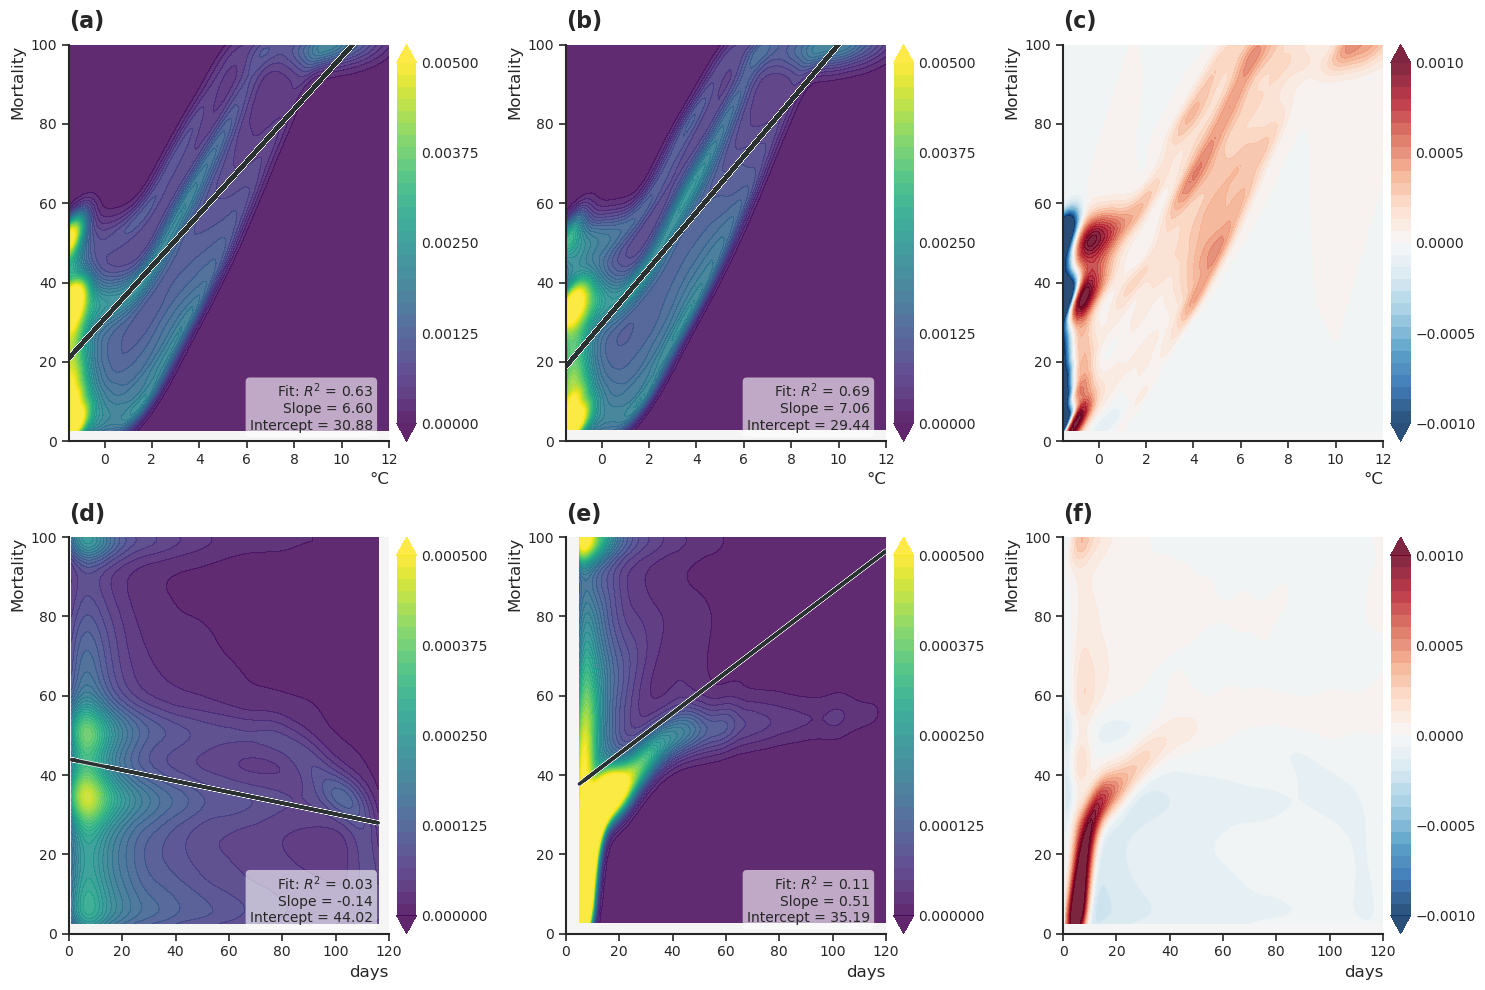

In [29]:
# 使用示例 -------------------------------------------------
# 创建画布和子图
plt.close('all')  # 关键！释放内存
fig, axes = plt.subplots(2,3, figsize=(15, 10))  # 创建1行2列的子图



# 在第一个子图绘制
plot_density_with_fit(pc31_mtpnan_flat, pc31_nan_flat, ax=axes[0,0], xlim=(-1.5,12),
                     title='(a)', xlabel='°C', cmap='viridis',clim=0.005)
plot_density_with_fit(pc31_mtpmhw_flat, pc31_mhw_flat, ax=axes[0,1], xlim=(-1.5,12),
                     title='(b)', xlabel='°C', cmap='viridis',clim=0.005)
plot_density_with_fit2(pc31_mtpmhw_flat, pc31_mhw_flat, pc31_mtpnan_flat, pc31_nan_flat, ax=axes[0,2], xlim=(-1.5,12),ylim=(0,100),
                     title='(c)', xlabel='°C', ylabel='Mortality', cmap='RdBu_r',clim=0.001)
plot_density_with_fit(pc31_duranan_flat, pc31_nan_flat, ax=axes[1,0], xlim=(0,120),
                      title='(d)',xlabel='days', cmap='viridis',clim=0.0005)
plot_density_with_fit(pc31_duramhw_flat, pc31_mhw_flat, ax=axes[1,1], xlim=(0,120),
                      title='(e)',xlabel='days', cmap='viridis',clim=0.0005)
plot_density_with_fit2(pc31_duramhw_flat, pc31_mhw_flat, pc31_duranan_flat,pc31_nan_flat, ax=axes[1,2], xlim=(0,120),ylim=(0,100),
                      title='(f)',xlabel='days', ylabel='Mortality', cmap='RdBu_r',clim=0.001)

plt.tight_layout()  # 自动调整子图间距
plt.savefig('figures/pc31_kde_preview.png', dpi=300)  # 低分辨率预览


plt.savefig('figures/pc31_kde_final_plot.pdf', 
           dpi=600, 
           bbox_inches='tight',
           metadata={'CreationDate': None})  # 正式保存
plt.show()
plt.close('all')  # 关键！释放内存

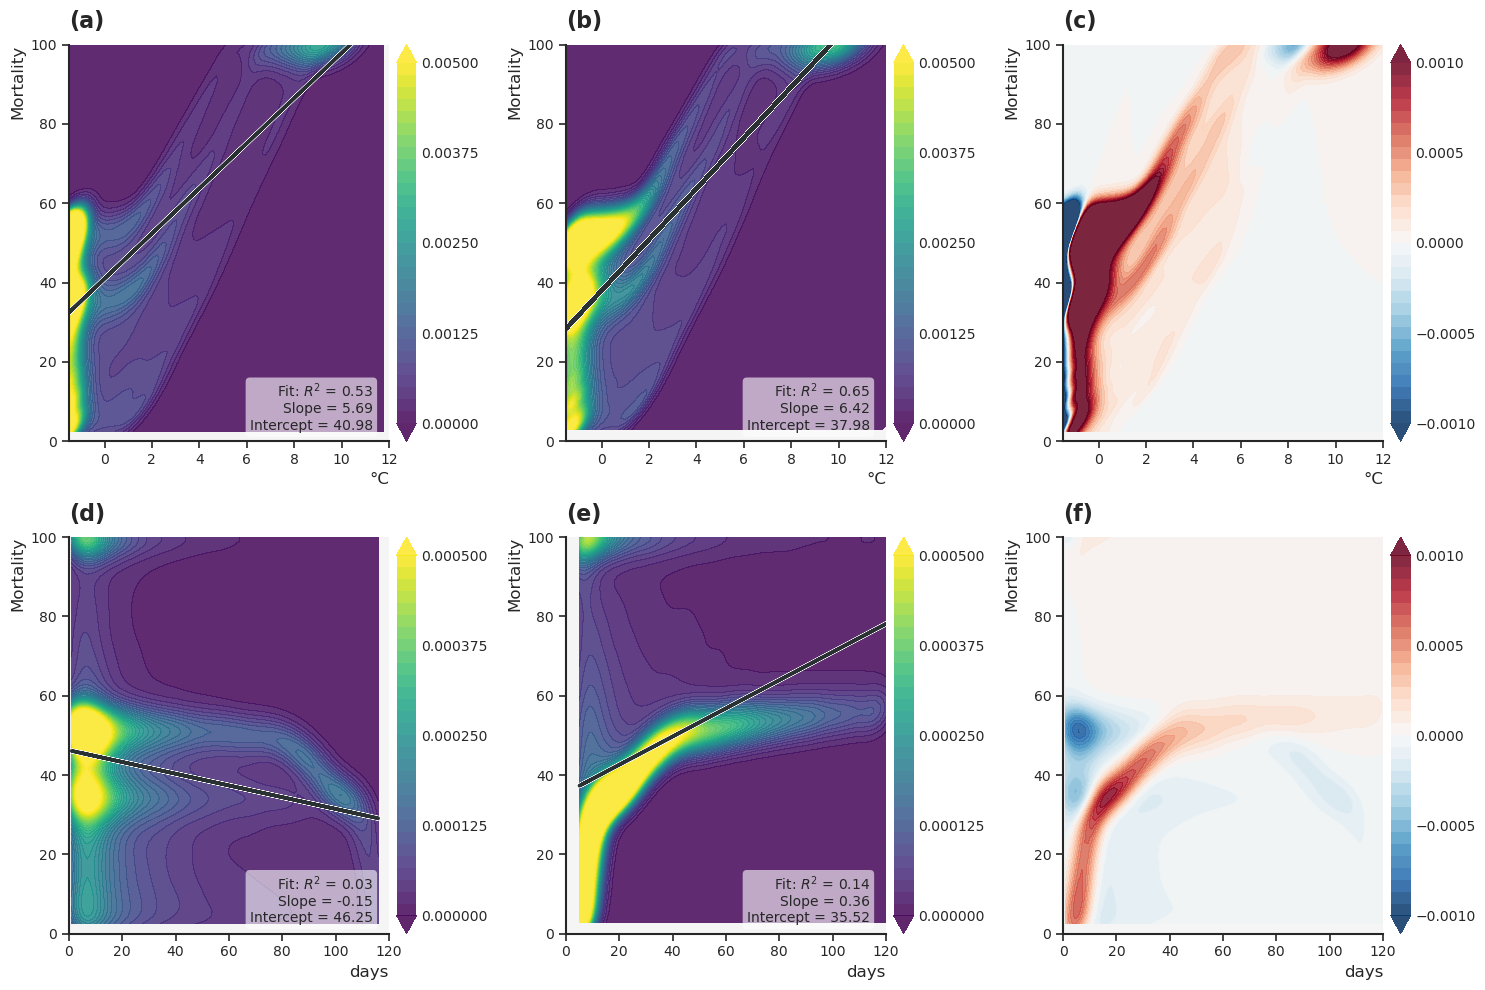

In [30]:
# 使用示例 -------------------------------------------------
# 创建画布和子图
plt.close('all')  # 关键！释放内存
fig, axes = plt.subplots(2,3, figsize=(15, 10))  # 创建1行2列的子图



# 在第一个子图绘制
plot_density_with_fit(pc42_mtpnan_flat, pc42_nan_flat, ax=axes[0,0], xlim=(-1.5,12),
                     title='(a)', xlabel='°C', cmap='viridis',clim=0.005)
plot_density_with_fit(pc42_mtpmhw_flat, pc42_mhw_flat, ax=axes[0,1], xlim=(-1.5,12),
                     title='(b)', xlabel='°C', cmap='viridis',clim=0.005)
plot_density_with_fit2(pc42_mtpmhw_flat, pc42_mhw_flat, pc42_mtpnan_flat, pc42_nan_flat, ax=axes[0,2], xlim=(-1.5,12),ylim=(0,100),
                     title='(c)', xlabel='°C', ylabel='Mortality', cmap='RdBu_r',clim=0.001)
plot_density_with_fit(pc42_duranan_flat, pc42_nan_flat, ax=axes[1,0], xlim=(0,120),
                      title='(d)',xlabel='days', cmap='viridis',clim=0.0005)
plot_density_with_fit(pc42_duramhw_flat, pc42_mhw_flat, ax=axes[1,1], xlim=(0,120),
                      title='(e)',xlabel='days', cmap='viridis',clim=0.0005)
plot_density_with_fit2(pc42_duramhw_flat, pc42_mhw_flat, pc42_duranan_flat,pc42_nan_flat, ax=axes[1,2], xlim=(0,120),ylim=(0,100),
                      title='(f)',xlabel='days', ylabel='Mortality', cmap='RdBu_r',clim=0.001)

plt.tight_layout()  # 自动调整子图间距
plt.savefig('figures/pc42_kde_preview.png', dpi=300)  # 低分辨率预览


plt.savefig('figures/pc42_kde_final_plot.pdf', 
           dpi=600, 
           bbox_inches='tight',
           metadata={'CreationDate': None})  # 正式保存
plt.show()
plt.close('all')  # 关键！释放内存